In [84]:
import gspread
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from google.oauth2.service_account import Credentials
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

import hdbscan

In [51]:
SERVICE_ACCOUNT_FILE = 'key/credentials.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

sheet = client.open('AI Summary Tagging').worksheet("negative_word")
data = sheet.get_all_values()

df = pd.DataFrame(data[1:], columns=data[0])

### Data Cleaning

In [50]:
df = df.iloc[:, [0, 1, 2, 3, 4, 5]].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date                    342 non-null    object
 1   Validator               342 non-null    object
 2   Ticket ID               342 non-null    object
 3   AFI                     342 non-null    object
 4   Type                    342 non-null    object
 5   Indikasi Kata Negative  342 non-null    object
dtypes: object(6)
memory usage: 16.2+ KB


In [52]:
df['AFI'] = df['AFI'].replace('','ASI')

TEXT_COL = "Indikasi Kata Negative"

sentences = (
    df.loc[(df['Date'] > '2025-12-1') & (df['Type'].eq('Kalimat')), TEXT_COL]
    .astype(str)
    .str.lower()
    .str.replace(r'[^\w\s]', ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
    .tolist()
)

print("jumlah kalimat: ", len(sentences))
print("Contoh 5 kalimat pertama: ")

for s in random.sample(sentences, min(len(sentences), 5)):
    print("-", s)

jumlah kalimat:  154
Contoh 5 kalimat pertama: 
- no va sudah sesuai tapi gagal terus
- kalau mau saya bayarkan itu ya buang bunganya krna saya tidak merasa memakai nya dan klopun tidak ya sudah terserah sya tidka akan bayarkan
- pastinya pihak akulaku ingin nya saya yg tanggung jawab selaku pemilik akun sedangkan saya tidak melakukan transaksi
- kendala pembayaran tagihan dana cicil
- tinggal satu biji lucky draw apaan ini pelit bget ni aplikasi akulaku


### Model

In [ ]:
# Semantic vector
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

embeddings = model.encode(sentences, show_progress_bar=True, convert_to_numpy=True)
embeddings.shape

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 384)

In [15]:
ex1 = sentences[random.randint(0, len(sentences)-1)]
ex2 = sentences[random.randint(0, len(sentences)-1)]

emb1 = model.encode(ex1, convert_to_numpy=True)
emb2 = model.encode(ex2, convert_to_numpy=True)

sim = util.cos_sim(emb1, emb2).item()
print("Cosine similarity:", round(sim, 3))

print(f"{ex1}\n{ex2}")

Cosine similarity: 0.201
tinggal satu biji lucky draw apaan ini pelit bget ni aplikasi akulaku
tidak mendapatkan bonus dari ajak teman


In [16]:
clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.45,
    metric="cosine",
    linkage="average"
)

labels = clustering.fit_predict(embeddings)
len(set(labels)), labels[:20]

(49,
 array([17, 38, 42,  3,  7, 41,  9,  1,  0,  0,  7,  0,  7, 18,  0, 15,  4,
        15,  7, 25]))

In [25]:
print(df.shape)
print(len(labels))

(342, 19)
154


In [54]:
cluster_sentences = df[(df['Date'] > '2025-12-1') & (df['Type'] == 'Kalimat')].reset_index(drop=True)
cluster_sentences['cluster'] = labels

cluster_sentences.sort_values(['cluster']).reset_index(drop=True)

,Date,Validator,Ticket ID,AFI,Type,Indikasi Kata Negative,cluster
0,2025-12-2,Azer,22080660,ASI,Kalimat,Pembayaran Akulaku Paylater tidak sesuai,0
1,2025-12-2,Azer,22078903,ASI,Kalimat,kenapa sudah bayar tetapi masih muncul,0
2,2025-12-2,Aulia,20285647,ASI,Kalimat,ingat saya sudah bayar ya!!,0
3,2025-12-2,Aulia,20561905,ASI,Kalimat,kalau mau saya bayarkan itu ya buang bunganya....,0
4,2025-12-2,Neneng,22476568,ASI,Kalimat,sudah bayar dana cicil namun masih dalam penag...,0
...,...,...,...,...,...,...,...
149,2025-12-5,Reza,21457185,ASI,Kalimat,Denda muncul 2 kali lipat,44
150,2025-12-3,Aulia,20518183,ASI,Kalimat,kalo emang tida bisa meminjam di aplikasi ini ...,45
151,2025-12-2,Reza,22298508,ASI,Kalimat,saya sudah semuanya tetapi tidak diverifikasi,46
152,2025-12-3,Aulia,20531716,ASI,Kalimat,saya minta bantuan ke OJK atau pihak berwajib,47


In [90]:
df.to_csv('negative_word_clustered.csv', index=False)

In [71]:
# The Score

sil_score = silhouette_score(embeddings, labels)
dbi = davies_bouldin_score(embeddings, labels)
ch = calinski_harabasz_score(embeddings, labels)

print(f"{sil_score:.3f} - Silhouette Score")
print(f"{dbi:.3f} - Davies-Bouldin Index")
print(f"{ch:.3f} - Calinski-Harabasz Score")

0.041 - Silhouette Score
0.918 - Davies-Bouldin Index
3.626 - Calinski-Harabasz Score


In [ ]:
# PCA
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(embeddings)

In [ ]:
# KMeans
scores = {}
for k  in range (2, 15):
    km = KMeans(n_clusters=k, random_state=42)
    labels_k = km.fit_predict(X_reduced)
    scores[k] = silhouette_score(X_reduced, labels_k)

scores

{2: 0.09755216538906097,
 3: 0.11659345030784607,
 4: 0.049480848014354706,
 5: 0.0723365843296051,
 6: 0.06157425418496132,
 7: 0.059005849063396454,
 8: 0.025869101285934448,
 9: 0.03389499709010124,
 10: 0.03856747969985008,
 11: 0.024049052968621254,
 12: 0.0235762782394886,
 13: 0.04575810953974724,
 14: 0.0319247804582119}

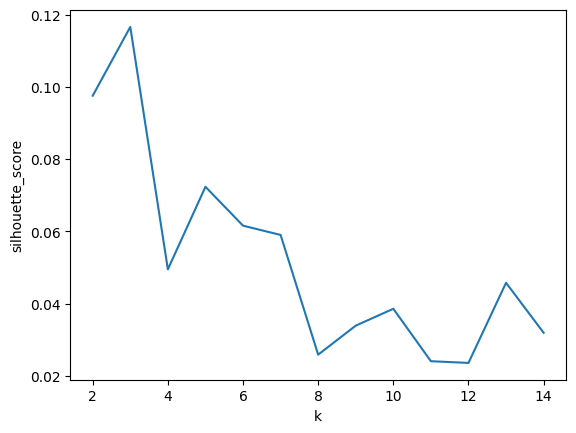

In [77]:
plt.plot(list(scores.keys()), list(scores.values()))
plt.xlabel("k")
plt.ylabel("silhouette_score")
plt.show()

In [ ]:
# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
labels = clusterer.fit_predict(X_reduced)

c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [81]:
# Normalize embedding
emb_norm = StandardScaler().fit_transform(embeddings)
emb_norm - normalize(embeddings)

array([[-1.5905889 ,  0.3689625 ,  0.348586  , ..., -1.018488  ,
         0.29968697,  0.7867783 ],
       [-0.07363488,  0.84987307,  0.4829319 , ...,  0.737844  ,
        -0.00749436,  0.3348192 ],
       [ 1.5791621 , -0.97523034,  0.44308174, ...,  2.0603852 ,
        -0.08296016,  1.3942546 ],
       ...,
       [ 0.4557628 ,  1.8815954 ,  0.37264612, ..., -0.44285125,
        -0.10558811, -0.4479225 ],
       [-0.39732295, -0.07552898, -0.5727705 , ..., -0.44622815,
        -0.82738394, -0.9357421 ],
       [ 0.08678874, -0.61068755, -0.25266495, ...,  0.16429168,
         1.3346496 ,  0.08642256]], shape=(154, 384), dtype=float32)

### Visualize

In [83]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=5,
    learning_rate=100
)

tsne_coords = tsne.fit_transform(embeddings)

In [57]:
df_tsne = cluster_sentences.copy().reset_index(drop=True)

assert tsne_coords.shape[0] == len(df_tsne), "Jumlah baris df dan embeddings harus sama"

df_tsne['tsne_x'] = tsne_coords[:, 0]
df_tsne['tsne_y'] = tsne_coords[:, 1]
df_tsne['cluster_id'] = labels

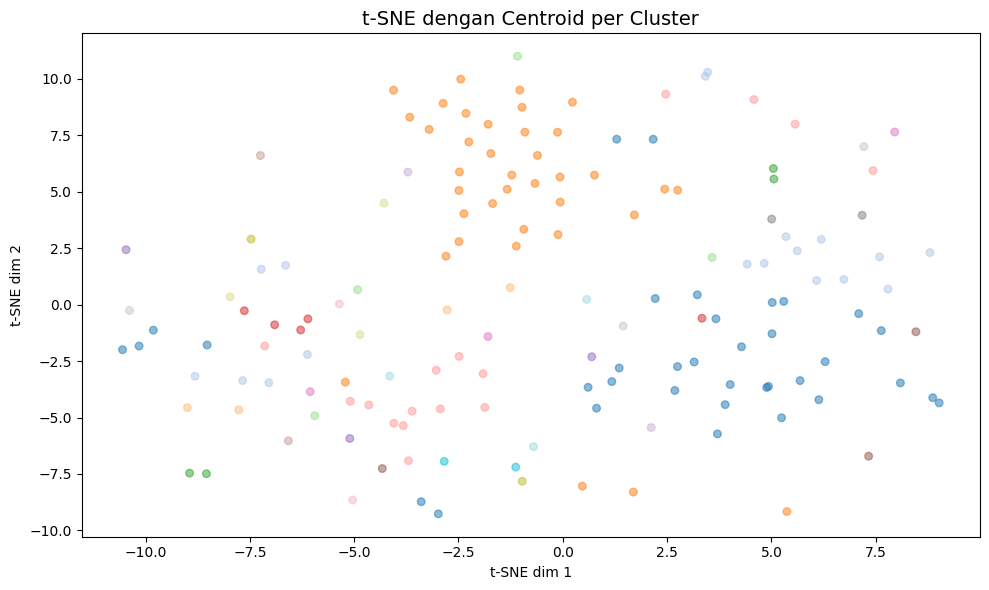

In [59]:
# ===== 5. Tambahkan titik rata-rata per cluster + 1 contoh kalimat =====

unique_clusters = np.unique(labels)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    df_tsne['tsne_x'],
    df_tsne['tsne_y'],
    c=df_tsne['cluster_id'],
    cmap='tab20',
    alpha=0.5,
    s=30
)

for cid in unique_clusters:
    sub = df_tsne[df_tsne['cluster_id'] == cid]
    cx = sub['tsne_x'].mean()
    cy = sub['tsne_y'].mean()
    
    # # plot centroid
    # plt.scatter(cx, cy, edgecolor='black', s=120, marker='X')
    # plt.text(
    #     cx, cy,
    #     f"C{cid}",
    #     fontsize=9,
    #     ha='center',
    #     va='center',
    #     bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7)
    # )

plt.title("t-SNE dengan Centroid per Cluster", fontsize=14)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()


### Model B

In [85]:
X = embeddings
X_norm = normalize(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_norm)

In [87]:
pca = PCA(n_components=20, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Jumlah dimensi setelah PCA:", X_pca.shape[1])
print("Total explained variance:", pca.explained_variance_ratio_.sum())

Jumlah dimensi setelah PCA: 20
Total explained variance: 0.7020388


In [90]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=3,
    metric='euclidean',
    cluster_selection_method='eom'
)

labels = clusterer.fit_predict(X_pca)

cluster_sentences['cluster_id'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Jumlah cluster ditemukan:", n_clusters)

unique, counts = np.unique(labels, return_counts=True)
print("Distribusi cluster:", dict(zip(unique, counts)))

Jumlah cluster ditemukan: 2
Distribusi cluster: {np.int64(-1): np.int64(76), np.int64(0): np.int64(9), np.int64(1): np.int64(69)}


c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [91]:
mask = labels != -1
X_eval = X_pca[mask]
labels_eval = labels[mask]

if mask.sum() > 10 and len(np.unique(labels_eval)) > 1:
    sil = silhouette_score(X_eval, labels_eval)
    dbi = davies_bouldin_score(X_eval, labels_eval)
    ch = calinski_harabasz_score(X_eval, labels_eval)

    print(f"{sil:.3f} - Silhouette Score (no noise)")
    print(f"{dbi:.3f} - Davies-Bouldin Index (no noise)")
    print(f"{ch:.3f} - Calinski-Harabasz Score (no noise)")
else:
    print("Temee")

0.215 - Silhouette Score (no noise)
1.462 - Davies-Bouldin Index (no noise)
12.037 - Calinski-Harabasz Score (no noise)


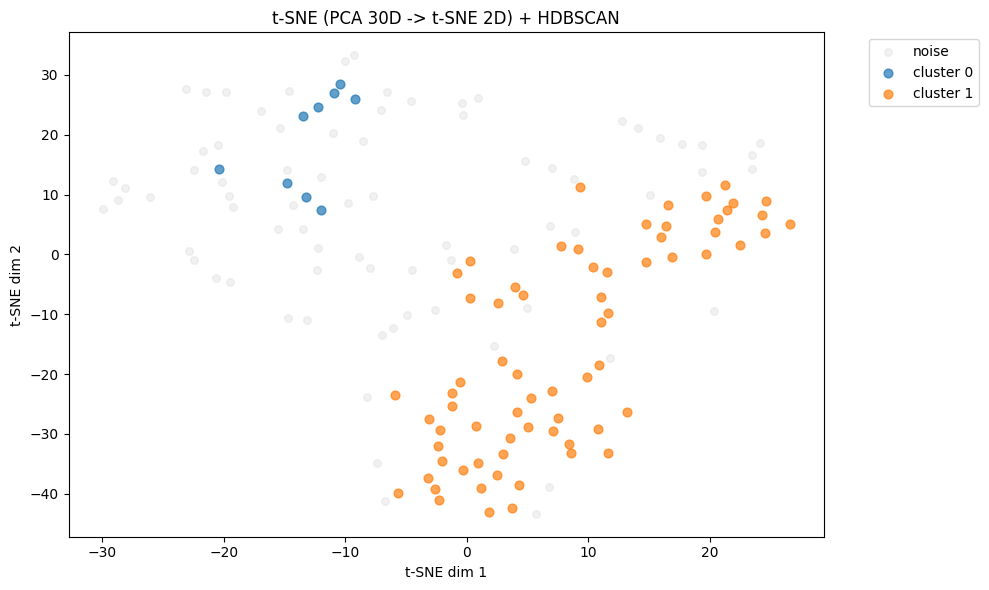

In [ ]:
tsne = TSNE(
    n_components=2,
    perplexity=10,
    learning_rate='auto',
    max_iter=1000,
    random_state=42,
    init='random'
)

X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(10, 6))

for cid in np.unique(labels):
    idx = labels == cid
    if cid == -1:
        plt.scatter(
            X_tsne[idx, 0], X_tsne[idx, 1],
            s=30, alpha=0.3, c="lightgray", label="noise"
        )
    else:
        plt.scatter(
            X_tsne[idx, 0], X_tsne[idx, 1],
            s=40, alpha=0.7, label=f"cluster {cid}"
        )

plt.title("t-SNE (PCA 30D --> t-SNE 2D) + HDBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [108]:
def show_examples(cluster_id, n=5, text_col="Indikasi Kata Negative"):
    subset = cluster_sentences[cluster_sentences["cluster_id"] == cluster_id]
    if subset.empty:
        print(f"Tidak ada data untuk cluster {cluster_id}")
        return

    sample = subset.sample(min(n, len(subset)), random_state=42)
    for i, row in sample.iterrows():
        print(f"[{cluster_id}] {row[text_col]}")
    print("-" * 60)

for cid in sorted(c for c in cluster_sentences["cluster_id"].unique() if c != -1):
    print(f"=== Cluster {cid} ===")
    show_examples(cid, n=5)  # sekarang text_col default sudah benar


=== Cluster 0 ===
[0] knp ngga di acc trus ya
[0] mau diganti tp tidak bisa
[0] kak pesanan saya kok g ada ya
[0] nasabah AKULAKU NAMUN SY TDK ADA TUNGGAKAN
[0] ko saya gabisa minjem ya di akulaku
------------------------------------------------------------
=== Cluster 1 ===
[1] Tidak bisa bayar tagihan via Alfamart
[1] tolong sy pusing,sy bilang pinjaman yg sy ajukan belum sy terima
[1] di ovo sudah berhasil tapi tagihannya kok tetep ada kak
[1] kenapa sudah bayar tetapi masih muncul
[1] pagi pak ko ini tiba" akun saya ngambil pinjaman
------------------------------------------------------------
